In [1]:
## 1. Importação das Bibliotecas

# Leitura, interpretação e plotar os dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Normalização e avaliação do modelo
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Construção do modelo LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from keras.models import load_model
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Bases para as variáveis de entrada (features)
# import yfinance as yf
# from bcb import sgs

# Tempo de compilação, variáveis do sistema e aleatoriedade
import time
import os
import random

In [2]:
## 2. Criação de uma SEED

SEED = 0

def criar_seed(seed=SEED):
  os.environ['PYTHONHASHSEED'] = str(seed) # Controla aleatoriedade interna do interpretador Python
  random.seed(seed) # Controla aleatoriedade da biblioteca random
  np.random.seed(seed) # Controla aleatoriedade do NumPy
  tf.random.set_seed(seed) # Controla aleatoriedade do TensorFlow (pesos, embaralhamento, etc)

def setar_deterministico(seed=SEED): # Garantir que se obtenha os mesmos valores ao rodar o código novamente
  criar_seed(seed=seed) # Setar as seeds
  os.environ['TF_DETERMINISTIC_OPS'] = '1' # Força o TensorFlow a usar operações determinísticas
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # Força operações determinísticas específicas da GPU (cuDNN)
  tf.config.threading.set_inter_op_parallelism_threads(1) # Limita o paralelismo entre operações a 1 thread
  tf.config.threading.set_intra_op_parallelism_threads(1) # Limita o paralelismo dentro de cada operação a 1 thread

setar_deterministico(SEED)  # Executa tudo acima com a seed escolhida

_start_time = time.time() # Calcular tempo

In [3]:
## 3. Construção do Modelo com GridSearchCV (2ª arquitetura)

X_train = np.load('../../Dados/Treinamento/B3SA3/X_train_B3SA3.npy')
X_test  = np.load('../../Dados/Treinamento/B3SA3/X_test_B3SA3.npy')
y_train = np.load('../../Dados/Treinamento/B3SA3/y_train_B3SA3.npy')
y_test  = np.load('../../Dados/Treinamento/B3SA3/y_test_B3SA3.npy')
scaler  = joblib.load('../../Dados/Treinamento/B3SA3/scaler_B3SA3.pkl')


def build_model(optimizer='adam'): # Função para criar o modelo LSTM como base para o GridSearchCV
    model = Sequential() # Cria um modelo sequencial (camadas empilhadas)
    model.add(LSTM(32, return_sequences=True, input_shape=(21, X_train.shape[2]))) # Primeira camada LSTM com 32 neurônios e retorno da sequência para a próxima LSTM
    model.add(LSTM(16)) # Segunda camada LSTM com 16 neurônios (sem return_sequences, pois é a última LSTM)
    model.add(Dense(10)) # Camada densa intermediária com 10 neurônios (pode ajudar a refinar a saída)
    model.add(Dense(1)) # Camada de saída com 1 neurônio (regressão: previsão de um único valor)
    model.compile(optimizer=optimizer, loss='mse') # Compila o modelo com o otimizador informado e função de erro MSE (erro quadrático médio)
    return model


model = KerasRegressor(model=build_model, verbose=1) # Envolve o modelo Keras dentro de um wrapper compatível com scikit-learn (necessário para o GridSearchCV)

params = { # Definição dos hiperparâmetros
    'batch_size': [5], # Tamanhos de lote a testar
    'epochs': [45], # Número de épocas de treino
    'optimizer': ['adam'] # Otimizador usado na compilação
}

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid = GridSearchCV(estimator=model, param_grid=params, scoring=mae_scorer, cv=4) # Inicializa o GridSearchCV para encontrar os melhores hiperparâmetros usando validação cruzada (cv=4)
grid_result = grid.fit(X_train, y_train) # Realiza o treinamento e busca dos melhores parâmetros

Epoch 1/45


c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0178
Epoch 2/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0024
Epoch 3/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0020
Epoch 4/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0018
Epoch 5/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0016
Epoch 6/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014
Epoch 7/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014
Epoch 8/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0013
Epoch 9/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0012
Epoch 10/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0011
Epoch 11/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0010    
Epoch 12/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9.8762e-04
Epoch 13/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.4022e-04
Epoch 14/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9.0115e-04
Epoch 15/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0089
Epoch 2/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0018
Epoch 3/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0016
Epoch 4/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0014
Epoch 5/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0013
Epoch 6/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0012
Epoch 7/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0011
Epoch 8/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0011
Epoch 9/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0010    
Epoch 10/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.5362e-04
Epoch 11/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.0752e-04
Epoch 12/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.6646e-04
Epoch 13/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.3057e-04
Epoch 14/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7.9999e-04
Epoch 15/45
200/200 ━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0114
Epoch 2/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0013
Epoch 3/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0011
Epoch 4/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.9475e-04
Epoch 5/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 9.1786e-04
Epoch 6/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8.6094e-04
Epoch 7/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8.1568e-04
Epoch 8/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.7777e-04
Epoch 9/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.4479e-04
Epoch 10/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.1523e-04
Epoch 11/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.8803e-04
Epoch 12/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.6245e-04
Epoch 13/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.3790e-04
Epoch 14/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.1398e-04
Epoch 15/4

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0065
Epoch 2/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0015
Epoch 3/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0012
Epoch 4/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0011    
Epoch 5/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 9.5645e-04
Epoch 6/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 8.8595e-04
Epoch 7/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.3300e-04
Epoch 8/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.9198e-04
Epoch 9/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.5925e-04
Epoch 10/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.3237e-04
Epoch 11/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.0962e-04
Epoch 12/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.8977e-04
Epoch 13/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.7194e-04
Epoch 14/45
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.5550e-04
Epoch 15/4

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


267/267 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0071
Epoch 2/45
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0017
Epoch 3/45
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0014
Epoch 4/45
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0011
Epoch 5/45
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0010
Epoch 6/45
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 9.5513e-04
Epoch 7/45
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 8.9611e-04
Epoch 8/45
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 8.4489e-04
Epoch 9/45
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 7.9815e-04
Epoch 10/45
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 7.5455e-04
Epoch 11/45
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 7.1382e-04
Epoch 12/45
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 6.7632e-04
Epoch 13/45
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 6.4250e-04
Epoch 14/45
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 6.1261e-04
Epoch 15/45
267/26

In [4]:
## 4. Avaliação do Modelo

best_model = grid_result.best_estimator_ # Recupera o melhor modelo encontrado pelo GridSearchCV
# pred = best_model.predict(X_test) # Faz a predição dos valores do conjunto de teste

# # Expande as previsões para 6 colunas simuladas (como se fossem as 6 features)
# pred_expand = np.repeat(pred.reshape(-1, 1), df.shape[1], axis=1) # Expande a predição para ter o mesmo número de colunas que o DataFrame original (necessário para desfazer a normalização)
# y_expand = np.repeat(y_test.reshape(-1, 1), df.shape[1], axis=1) # Faz o mesmo com os valores reais (y_test), para poder comparar os dados reais com os previstos no mesmo formato

pred = best_model.predict(X_test).reshape(-1)  # (N,)

# Nº de features que o scaler viu ao treinar
n_features = getattr(scaler, "n_features_in_", None)
if n_features is None:
    # fallback seguro se você normalizou antes de criar janelas
    n_features = X_train.shape[2]

# Índice da coluna alvo no DF original normalizado (ajuste se não for 0)
target_idx = 0

# Monte matrizes com o mesmo nº de colunas do scaler e preencha só a target
pred_expand = np.zeros((pred.shape[0], n_features), dtype=float)
pred_expand[:, target_idx] = pred

y_expand = np.zeros((y_test.shape[0], n_features), dtype=float)
y_expand[:, target_idx] = y_test.reshape(-1)

# Inverte a normalização e pega só a primeira coluna (Close_VALE3)
pred_real = scaler.inverse_transform(pred_expand)[:, 0] # Inverte a normalização nas previsões e pega só a 1ª coluna (preço da VALE3)
y_real = scaler.inverse_transform(y_expand)[:, 0] # Inverte a normalização nos valores reais (y_test) e pega só a 1ª coluna

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [5]:
## 5. Salvar o modelo e todas as informações necessárias

melhor_modelo = grid.best_estimator_.model_

# Salvar o melhor modelo encontrado pelo GridSearchCV com o .h5
melhor_modelo.save('Modelo_B3SA3.h5')

# Salvar o melhor modelo encontrado pelo GridSearchCV com o .keras
melhor_modelo.save('Modelo_B3SA3.keras', save_format='keras')

# Salvar scaler
joblib.dump(scaler, 'scaler_B3SA3.pkl')

# Salvar X_test e y_test (usado para fazer nova previsão depois)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

# Salvar previsões e reais desnormalizadas (para plot futuro sem rodar nada)
np.save('pred_real.npy', pred_real)
np.save('y_real.npy', y_real)

In [6]:
## 6. Métricas

melhor_modelo.summary() # Resumo da arquitetura do modelo LSTM, incluindo camadas, formatos de entrada/saída e número de parâmetros treináveis

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 21, 32)         │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,929 (97.38 KB)

 Trainable params: 8,309 (32.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,620 (64.93 KB)

In [7]:
## 6. Métricas

print("MAE:", mean_absolute_error(y_real, pred_real)) # Erro absoluto médio (MAE)
print("MAPE:", mean_absolute_percentage_error(y_real, pred_real)) # Erro percentual médio absoluto (MAPE)
print("R²:", r2_score(y_real, pred_real)) # R² (quanto o modelo explica da variabilidade dos dados)

MAE: 0.28024640527732614
MAPE: 0.024129981617148712
R²: 0.9264642010851498


In [8]:
## 6. Métricas

resultados = pd.DataFrame(grid_result.cv_results_) # Transforma em um DataFrame
display(resultados[['params', 'mean_test_score', 'rank_test_score']]) # Exibe os hiperparâmetros testados, a média de desempenho e o ranking

,params,mean_test_score,rank_test_score
0,"{'batch_size': 5, 'epochs': 45, 'optimizer': '...",-0.018752,1


In [9]:
## 6. Métricas

grid_result.best_params_ # Exibe os hiperparâmetros do melhor modelo

{'batch_size': 5, 'epochs': 45, 'optimizer': 'adam'}

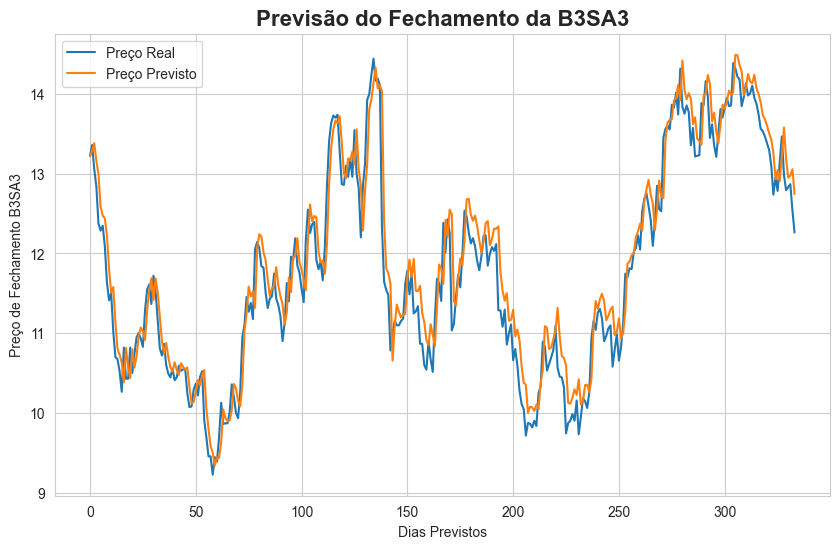

In [10]:
## 7. Gráfico

plt.figure(figsize = (10, 6))
sns.set_style('whitegrid')

plt.plot(y_real, label='Preço Real')
plt.plot(pred_real, label='Preço Previsto')

plt.xlabel('Dias Previstos')
plt.ylabel('Preço de Fechamento B3SA3')
plt.title('Previsão do Fechamento da B3SA3', fontweight='bold', fontsize=16)
plt.legend()

plt.show()

In [11]:
## 8. Tempo Final de Compilação

_end_time = time.time() - _start_time
print(f"Tempo total de execução: {_end_time:.2f} segundos")

Tempo total de execução: 694.09 segundos
